# Text Classification of two artists/bands

In [184]:
#Libraries
import requests
import re
import time 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Modules for data-processing 
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Model-evaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score

## 1. Web-scraping a corpus and data-processing

### 1.1 Scraping the lyrics of all Manowar-songs

#### 1.1.1 Scraping the url-list and lyrics

In [2]:
page = requests.get('https://www.lyrics.com/artist/Manowar/13602')

In [3]:
# Creation of a file for the url-list
f = open("Manowar.txt", "w")
f.write(page.text)
f.close()

# Open and read the file after the appending:
f = open("Manowar.txt", "r")
text_read= f.read()
f.close()

f = open("Manowar.txt", "a")
f.close()

In [4]:
# Reading the file for further precprocessing
f = open('Manowar.txt','r')
text2 = f.read()
f.close()

In [5]:
# Extracting all the links from the txt-file 
hyper_list = re.findall('/lyric/[^\"]+', text2)
hyper_list[0:3]

['/lyric/33868847/Manowar/Fighting+the+World',
 '/lyric/32625817/Manowar/Blow+Your+Speakers',
 '/lyric/30652516/Manowar/Perfect+Strangers']

In [6]:
# Combing of the extractions with the general url of the site for a complete list
prefix_url = 'https://www.lyrics.com'
complete_url_list = [prefix_url + link for link in hyper_list]

In [7]:
complete_url_list[0:3]

['https://www.lyrics.com/lyric/33868847/Manowar/Fighting+the+World',
 'https://www.lyrics.com/lyric/32625817/Manowar/Blow+Your+Speakers',
 'https://www.lyrics.com/lyric/30652516/Manowar/Perfect+Strangers']

In [9]:
# Extracting all HTML-files from the songs
for song in complete_url_list:
    #time.sleep(1)
    lyr = requests.get(song).text
    name = re.findall('/Manowar[^\">]+', song)
    f = open(f'../week4/{name[0]}.txt','w')
    f.write(lyr)
    f.close()

In [10]:
# Extraction of one song 
f_o = open('Manowar/King.txt', "r")
mking= f_o.read()

In [11]:
#Parsing the HTML-document
manowar_soup = BeautifulSoup(mking, 'html.parser')

In [12]:
manowar_soup.find(class_='lyric-body').text

"Now Is The Time To Reach For The Sky\nGather The Wind Hear The Voice To Fly\nTo Know Why They Sing About Heroes And Kings\nWho Were Brave And Not Afraid To Die\nLook And You'll See That A New Day Will Bring\nThe Will To Go On And Fight Trough Endless Suffering\nFor All Who Believe Wait A Crown A Ring\n\nThe Power Of The Man Who Would Be King\nThe Power Of The Man Who Would Be King\n\nInto The Fight Of Hopes And Dreams\nThe Master Of The Wind Knows Nothing's What It Seems\nThe Melting Of The Soul The Wish Of Those Who Scheme\nThe Taking Of The Will By Destroyers Of The Dream\nThey Live To Spread The Fear Of The Wrong Of Right Of Self\nThey Want Us All To Live Like Books Upon A Shelf\nBut We Know We Have The Power To Fight And Make A Stand\nStrike When We Are Challenged All Across The Land To Be King\n\nFight For The Crown, Fight For The Ring\nWe're Fighting The World, We Fight For The King\n\nTime To Face The World Let Brothers Never Fight\nForever Forge Ahead And Keep The Dream In Sig

In [15]:
# Scarping all listed songs of Manowar and extracting the lyrics via BS
mow_compltxt = []
for fn in os.listdir('../week4/Manowar/'):
    text_Mow = open('../week4/Manowar/'+ fn).read()
    mow_comp_soup = BeautifulSoup(text_Mow, 'html.parser')
    # Got a 'Nonetype'-error and this is the solution from Stackoverflow:
    k = getattr(mow_comp_soup.find(class_='lyric-body'), 'text', None)
    if k is not None: #Got this from Till 
        mow_compltxt.append(k)

#### 1.1.2 Preprocessing the lyrics 

In [16]:
# Cleaning the lyrics
def preprocess_cleaning(corpus):
    """This function preprocesses the corpus before feature-extraction
    """
    corpus_cleaned = []
    for lyric in corpus:
        lyric = lyric.lower()
        lyric = re.sub(r"(\w+)\'ll",r'\g<1> will',lyric) # e.g. I'll --> I will 
        lyric = re.sub(r"(\w+)\'ve",r'\g<1> have',lyric) # e.g. we've --> we have
        lyric = re.sub(r"don\'t","do not",lyric) # don't --> do not
        lyric = re.sub(r'(\w+)\'s','\g<1> is',lyric) # e.g she's --> she is 
        lyric = re.sub(r"(\w+)\'","\g<1>g",lyric) # e.g burnin' --> burning
        lyric = re.sub(r"[\W]"," ",lyric) # remove not alphanumeric aka punctuation
        corpus_cleaned.append(lyric)
    return corpus_cleaned

In [17]:
mow_cleaned = preprocess_cleaning(mow_compltxt)

In [18]:
mow_cleaned[0:1]

['burning embers of the second death will come in the night priests and kings  the alpha and omega  poison bites false prophets and deceivers swing from the trees now dawn the age of birds drunk with blood  like lepers with disease lord of the sky mercury the guide lord of the underworld  i swear the sacred right i will crucify  slay them with their tribe hear my war cry  they will find no sanctuary hidden in their ancestral halls let loose the knot that binds the spirit and flesh let it fall for only courage and heroism linger after death so  hold fast thy sword  rejecting pain  feel the dragons breath  i have sworn the oath']

#### 1.1.3 Creating a textfile for the wordcount

In [19]:
mow_cleanedtxt = open("mow_cleanedtxt", "w")
for word in mow_cleaned:
    mow_cleanedtxt.write(word + "\n")
mow_cleanedtxt.close()

In [20]:
words = re.findall(r'\w+', open('mow_cleanedtxt').read().lower())
Counter(words).most_common(10)

[('the', 1501),
 ('and', 670),
 ('of', 574),
 ('to', 512),
 ('i', 438),
 ('we', 363),
 ('is', 361),
 ('a', 332),
 ('in', 295),
 ('my', 274)]

#### 1.1.4 Creating a wordcloud

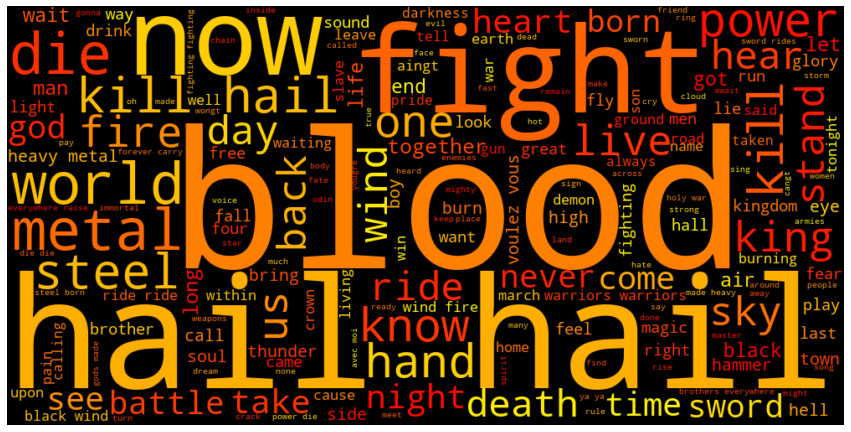

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#convert list to string and generate
unique_string=(" ").join(mow_cleaned)
stopwords = set(STOPWORDS)
stopwords.update(["wegre", "igm", "voulez vous", "ya ya", "ah", "ha", "will"])

wordcloud = WordCloud(width = 1000, height = 500, background_color="black", stopwords=stopwords, colormap="autumn").generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("Manowar_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

### 1.2 Scraping the lyrics of all Type O Negative-songs

#### 1.2.1 Scraping the url-list and lyrics

In [22]:
page = requests.get('https://www.lyrics.com/album/2709323/The-Complete-Roadrunner-Collection-1991-2003')

In [23]:
# Creation of a file for the url-list
f = open("ToN.txt", "w")
f.write(page.text)
f.close()

# Open and read the file after the appending:
f = open("ToN.txt", "r")
text_read= f.read()
f.close()

f = open("ToN.txt", "a")
f.close()

In [24]:
# Reading the file for further precprocessing
f = open('ToN.txt','r')
text2 = f.read()
f.close()

In [25]:
# Extracting all the links from the txt-file 
hyper_list = re.findall('/lyric/[^\"]+', text2)
hyper_list[0:5]

['/lyric/29194110/Unsuccessfully+Coping+With+the+Natural+Beauty+of+Infidelity',
 '/lyric/28874711/Der+Untermensch',
 '/lyric/29194108/Xero+Tolerance',
 '/lyric/29194107/Prelude+To+Agony',
 '/lyric/28874699/Kill+You+Tonight+%28Reprise%29']

In [26]:
# Combing of the extractions with the general url of the site for a complete list
prefix_url = 'https://www.lyrics.com'
complete_url_list = [prefix_url + link for link in hyper_list]

In [27]:
complete_url_list[0:5]

['https://www.lyrics.com/lyric/29194110/Unsuccessfully+Coping+With+the+Natural+Beauty+of+Infidelity',
 'https://www.lyrics.com/lyric/28874711/Der+Untermensch',
 'https://www.lyrics.com/lyric/29194108/Xero+Tolerance',
 'https://www.lyrics.com/lyric/29194107/Prelude+To+Agony',
 'https://www.lyrics.com/lyric/28874699/Kill+You+Tonight+%28Reprise%29']

In [28]:
# Extracting all HTML-files from the songs
for song in complete_url_list:
    #time.sleep(1)
    lyr = requests.get(song).text
    name = re.findall('\d[^\">]+', song)[0].split('/')[1]
    f = open(f'../week4/ToN/{name}.txt','w')
    f.write(lyr)
    f.close()
  

In [29]:
# Scraping all listed songs of Manowar and extracting the lyrics via BS
ToN_compltxt = []
for fn in os.listdir('../week4/ToN/'):
    text_ToN = open('../week4/ToN/'+ fn).read()
    ToN_comp_soup = BeautifulSoup(text_ToN, 'html.parser')
    # Got a 'Nonetype'-error and this is the solution from Stackoverflow:
    k = getattr(ToN_comp_soup.find(class_='lyric-body'), 'text', None)
    if k is not None: #Got this from Till 
        ToN_compltxt.append(k)

In [30]:
ToN_compltxt[0]

"Agony and ecstacy\nYour cries of pain my pleasure\nTo know my machine internally\nYour torment I treasure\n\nLifeblood combines with semen\nYour screaming my laughter\nThe compressor is running smoothly\n'Tis vengeance I am after\n\nPain\n\nBegging becomes your lovesong\nYou're dying\nI masturbate\nFor the crime of burning me\nI give to thee\nJackhammerape\n\nHatred obsessing me\nHatred possessing me\nAnger burning me\nAnger turning me\nInto someone I don't know\n\nRage shaking me\nRage making me\nInto someone I don't know\nI'll kill you tonight"

#### 1.2.2 Preprocessing the lyrics

In [31]:
# Cleaning the lyrics
ToN_cleaned = preprocess_cleaning(ToN_compltxt)

In [32]:
ToN_cleaned[0]

'agony and ecstacy your cries of pain my pleasure to know my machine internally your torment i treasure  lifeblood combines with semen your screaming my laughter the compressor is running smoothly  tis vengeance i am after  pain  begging becomes your lovesong yougre dying i masturbate for the crime of burning me i give to thee jackhammerape  hatred obsessing me hatred possessing me anger burning me anger turning me into someone i do not know  rage shaking me rage making me into someone i do not know i will kill you tonight'

#### 1.2.3 Creating a textfile for the wordcount

In [33]:
ToN_cleanedtxt = open("ToN_cleanedtxt", "w")
for word in ToN_cleaned:
    ToN_cleanedtxt.write(word + "\n")
ToN_cleanedtxt.close()

In [34]:
words = re.findall(r'\w+', open('ToN_cleanedtxt').read().lower())
Counter(words).most_common(10)

[('i', 278),
 ('the', 270),
 ('you', 219),
 ('is', 151),
 ('and', 141),
 ('to', 139),
 ('of', 130),
 ('me', 124),
 ('a', 119),
 ('my', 100)]

#### 1.2.4 Creating a wordcloud

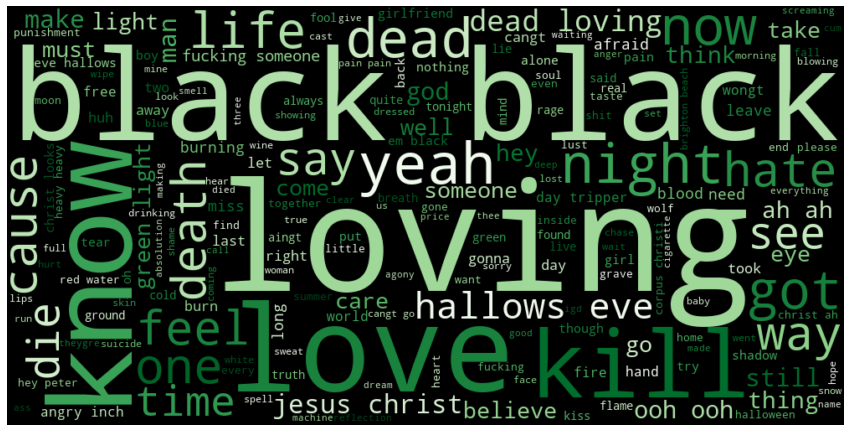

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#convert list to string and generate
unique_string=(" ").join(ToN_cleaned)
stopwords = set(STOPWORDS)
stopwords.update(["wegre", "igm", "yougre", "dye", "will", "hum", "yum", "eatgem", "ya"])

wordcloud = WordCloud(width = 1000, height = 500, background_color="black", stopwords=stopwords, colormap="Greens").generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("ToN_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

### 1.3 Combination of the data 

In [36]:
# Combining the strings of the lyrics of both artists into one
corp_clean = mow_cleaned + ToN_cleaned

In [37]:
print(len(corp_clean))

159


In [38]:
print(len(mow_cleaned)), print(len(ToN_cleaned))

95
64


(None, None)

### 1.4 Definition of the X- and y-features and split

In [71]:
# Defining the features
X  = corp_clean

In [128]:
# Defining the y-variable
y = ['Manowar'] * 95 + ['Type O Negative'] * 64

In [129]:
# Label-encoding the strings in integers
le = LabelEncoder()
y = le.fit_transform(y)
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Manowar': 0, 'Type O Negative': 1}


In [107]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

### 1.5 Vectorization and transformation

In [108]:
# Initializing the vectorizer
cv = CountVectorizer(stop_words='english')

In [130]:
# Vectorizing the corpus
X_train_v = cv.fit_transform(X_train)

In [131]:
X_test_t = cv.transform(X_test)

In [132]:
# Shape of the coprus
X_train_v.shape 

(119, 2468)

In [122]:
X_train_v

<119x2468 sparse matrix of type '<class 'numpy.int64'>'
	with 6568 stored elements in Compressed Sparse Row format>

In [123]:
# Rows
print(X_train_v)

  (0, 1478)	1
  (0, 1289)	1
  (0, 1711)	2
  (0, 2365)	1
  (0, 331)	1
  (0, 1027)	1
  (0, 992)	1
  (0, 1887)	2
  (0, 1197)	1
  (0, 2002)	1
  (0, 1831)	1
  (0, 942)	1
  (0, 229)	1
  (0, 2391)	1
  (0, 1975)	1
  (0, 751)	1
  (0, 2418)	3
  (0, 1256)	1
  (0, 1023)	1
  (0, 891)	2
  (0, 1819)	1
  (0, 1413)	1
  (0, 2359)	1
  (0, 189)	1
  (0, 1041)	1
  :	:
  (118, 1294)	2
  (118, 1450)	2
  (118, 1932)	1
  (118, 1022)	2
  (118, 1467)	3
  (118, 930)	1
  (118, 1056)	1
  (118, 1639)	1
  (118, 358)	1
  (118, 474)	2
  (118, 1098)	1
  (118, 1789)	1
  (118, 2311)	1
  (118, 165)	1
  (118, 1020)	1
  (118, 803)	1
  (118, 535)	1
  (118, 2068)	1
  (118, 1441)	1
  (118, 753)	1
  (118, 1105)	1
  (118, 2074)	1
  (118, 109)	1
  (118, 848)	1
  (118, 369)	2


In [124]:
# Transforming the coprus to dense 
print(X_train_v.todense())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [134]:
# Conversion into a dataframe
df = pd.DataFrame(X_train_v.todense(),columns=cv.get_feature_names())

In [135]:
df.iloc[:,15:]

,ace,achilles,aching,acrid,actions,ad,adams,addicted,addiction,adore,...,yourgre,youth,youths,yum,zeigt,zeus,ziel,zu,zum,zurück
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.6 TF-IDF-Normalization 

In [145]:
# Initialisation of the Tfidf-Transformer
tfidf = TfidfTransformer()

In [168]:
# Fitting the corpus to the transformer
X_train_tfidf_matr = tfidf.fit_transform(X_train_v)

In [169]:
# Display of the  inverse document frequency (IDF) 
idf_df = pd.DataFrame(tfidf.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
idf_df.sort_values(by=['idf_weights'])

,idf_weights
know,1.980829
igm,2.003302
blood,2.026292
die,2.123930
like,2.203973
...,...
huh,5.094345
howls,5.094345
howl,5.094345
flight,5.094345


In [170]:
# Conversion of the tfidf-matrix to a dataframe 
X_train_tfidf= pd.DataFrame(tfidf_matr.todense(),columns=cv.get_feature_names())

In [171]:
X_train_tfidf.iloc[:,:25]

,141592653,18,1922,1943,1970,1st,28th,62,abandon,abode,...,ace,achilles,aching,acrid,actions,ad,adams,addicted,addiction,adore
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099049,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Model building

### 2.1 Logistic regression

In [189]:
#Initializing the Log. regression and fitting the model to the data
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)
logreg.score(X_test_t, y_test)

0.8

#### 2.1.2 Prediction on new documents

In [173]:
new_docs = ["Born of Black wind fire and steel", #Manowar
            "When we get up we're gonna kick your ass",#Manowar
            "To the battle we ride we crossed a starlit sky", #Manowar
            "Gone are the days when freedom shone", #Manowar
            "Black candles slowly burning", #Manowar
            "My chains and collar brought her to her knees", #Manowar
            "Before her surrender she had no life", #Manowar
            "Well I loved my aunt but she died", #ToN
            "I want to live with a cinnamon girl",#ToN
            "In the shadow of the light from a black sun", #ToN
            "Hey wolf moon come cast your spell on me", #ToN
            "Black lipstick stains her glass of red wine",# ToN
            "Life is coming to an end",#ToN
            "I'll kill you tonight"] #ToN

# Preprocessing of the data
new_doc_cleaned = preprocess_cleaning(new_docs)

#CountVectorizer and TfidfTransformer
new_doc_vect = cv.transform(new_doc_cleaned).todense()
new_doc_tfidf = tfidf.transform(new_doc_vect).todense() 

In [174]:
print(logreg.predict(new_doc_tfidf))
# Manowar = 0, ToN = 1

[0 0 0 0 0 0 0 0 0 0 1 1 0 1]


In [175]:
logreg.predict_proba(new_doc_tfidf)

array([[0.75792677, 0.24207323],
       [0.59775991, 0.40224009],
       [0.66888009, 0.33111991],
       [0.54314015, 0.45685985],
       [0.55943532, 0.44056468],
       [0.55668856, 0.44331144],
       [0.549313  , 0.450687  ],
       [0.51227569, 0.48772431],
       [0.56503708, 0.43496292],
       [0.51817939, 0.48182061],
       [0.46048185, 0.53951815],
       [0.48864352, 0.51135648],
       [0.55283319, 0.44716681],
       [0.49755615, 0.50244385]])

### 2.2 Naive Bayes

In [176]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb.score(X_test_t, y_test) 

0.75

#### 2.2.2 Prediction on new documents

In [177]:
new_docs = ["Born of Black wind fire and steel", #Manowar
            "When we get up we're gonna kick your ass",#Manowar
            "To the battle we ride we crossed a starlit sky", #Manowar
            "Gone are the days when freedom shone", #Manowar
            "Black candles slowly burning", #Manowar
            "My chains and collar brought her to her knees", #Manowar
            "Before her surrender she had no life", #Manowar
            "Well I loved my aunt but she died", #ToN
            "I want to live with a cinnamon girl",#ToN
            "In the shadow of the light from a black sun", #ToN
            "Hey wolf moon come cast your spell on me", #ToN
            "Black lipstick stains her glass of red wine",# ToN
            "Life is coming to an end",#ToN
            "I'll kill you tonight"] #ToN

# Preprocessing of the data
new_doc_cleaned = preprocess_cleaning(new_docs)

#CountVectorizer and TfidfTransformer
new_doc_vect = cv.transform(new_doc_cleaned).todense()
new_doc_tfidf = tfidf.transform(new_doc_vect).todense() 

In [178]:
nb.predict(new_doc_tfidf)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [179]:
nb.predict_proba(new_doc_tfidf)

array([[0.91473153, 0.08526847],
       [0.72290902, 0.27709098],
       [0.83046516, 0.16953484],
       [0.62927187, 0.37072813],
       [0.65135201, 0.34864799],
       [0.65438146, 0.34561854],
       [0.62370234, 0.37629766],
       [0.53795983, 0.46204017],
       [0.66594868, 0.33405132],
       [0.58084645, 0.41915355],
       [0.46052015, 0.53947985],
       [0.48893378, 0.51106622],
       [0.65070542, 0.34929458],
       [0.62652895, 0.37347105]])